## <center> <b>Computer Vision (CSE-6239)</b></center>
### <center> <b>Programming Assignment</b></center>

#### <center><b>  Interest Point Matching And Find Homography Matrix </b></center>

<div align="right">
    <b> Md. Omar Faruq <br> Roll: 1807557 </b>
</div> 

<p id = "top"> <a href="#Task_1" style="color:black;" > <b>1. Find corners (at least 20)using Harris corner detector from two different images</b></a>
<ol type="i"> <li>Show the found corneron the images</li></ol>
</p>
<p> <a href="#Task_2" style="color:black;" > <b>2. Use SIFT like or MOPS (Multiscale Oriented Patches) descriptor</b></a>
<ol type="i"> <li>Present a graphical representation of the descriptors</li></ol>
</p>

<p> <a href="#Task_3" style="color:black;" > <b>3. Find matches   among   the   key   points   using different   (Euclidian, cosine similarity, correlation, SSD,Nearest neighbor ratio)</b></a>
<ol type="i"> <li>Show the matching pair in a side-by-side image</li></ol>
</p>

<p><a href="#Task_4" style="color:black;" ><b>4. Manually/Automatically chose at least four matching pairand represent and show them as Ah=0 form, where h is projective transformation / homographyparameters.</b></a>
</p>

<p><a href="#Task_5" style="color:black;" ><b>5. Find  homography  matrix H  by  solving  the  Eqn  Ah=0  using  the  technique  of solving Homogeneous linear system or Homogeneous least square linear system.</b></a>
<ol type="i"> <li>Explain the method of solving in the report as well as the solution.</li></ol>
</p>

<p><a href="#Task_6" style="color:black;" ><b>6. Apply H to transformfirst image into a homographictransformed versionusing backward warping, also show all the images (first, 2nd, and the homographic transformed)side-by-side.Also showthe difference between 2nd and transformedimages</b></a>
</p>

In [76]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from scipy import ndimage
from pylab import *
from numpy import *
import sys 
import random
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
# Read images 
img1 = cv2.imread('NotreDame1.jpg')
img2 = cv2.imread('NotreDame2.jpg')
# RGB to GRAY CONVERT
gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

<p id="Task_1"> <b>1. Find corners (at least 20) using Harris corner detector from two different images</b> </p>

In [3]:
# Define Harris Corner Detection Function 

def findHarrisCorner(image, window_size = 5, k = 0.04, thres = 10000):
    
    # Find image gardient 
    
    # Sobel X and Y derivatives 
    dx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    dy = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5) 
    
    # Products of derivatives
    Ixx = dx**2 
    Iyy = dy**2
    Ixy = dx * dy
    
    height = image.shape[0] # image height
    width = image.shape[1] # image width
    
    newImg = image.copy()
    
    color_img = cv2.cvtColor(newImg, cv2.COLOR_GRAY2RGB) # Gray to RGB convert 
    offset = int(window_size / 2) 
    
    #loop over through image and find corners
    for y in range(offset, height-offset):
            for x in range(offset, width-offset):
                
                # Shift Intensity 
                windowIxx = Ixx[y - offset:y + offset + 1, x - offset:x + offset + 1]
                windowIxy = Ixy[y - offset:y + offset + 1, x - offset:x + offset + 1]
                windowIyy = Iyy[y - offset:y + offset + 1, x - offset:x + offset + 1]
                
                # Calculate sum of square 
                Sxx = windowIxx.sum()
                Syy = windowIyy.sum()
                Sxy = windowIxy.sum()
                
                # Find determinant and trace that use to get corners
                det = (Sxx * Syy) - (Sxy**2)
                trace = Sxx + Syy
                
                # Response score 
                R = det - k * (trace**2)
                #print('r', R)
                
                #If corner response is over threshold then color(Red) the point location
                if R > thres:
                    color_img.itemset((y, x, 0), 255)
                    color_img.itemset((y, x, 1), 0)
                    color_img.itemset((y, x, 2), 0)               
    return color_img

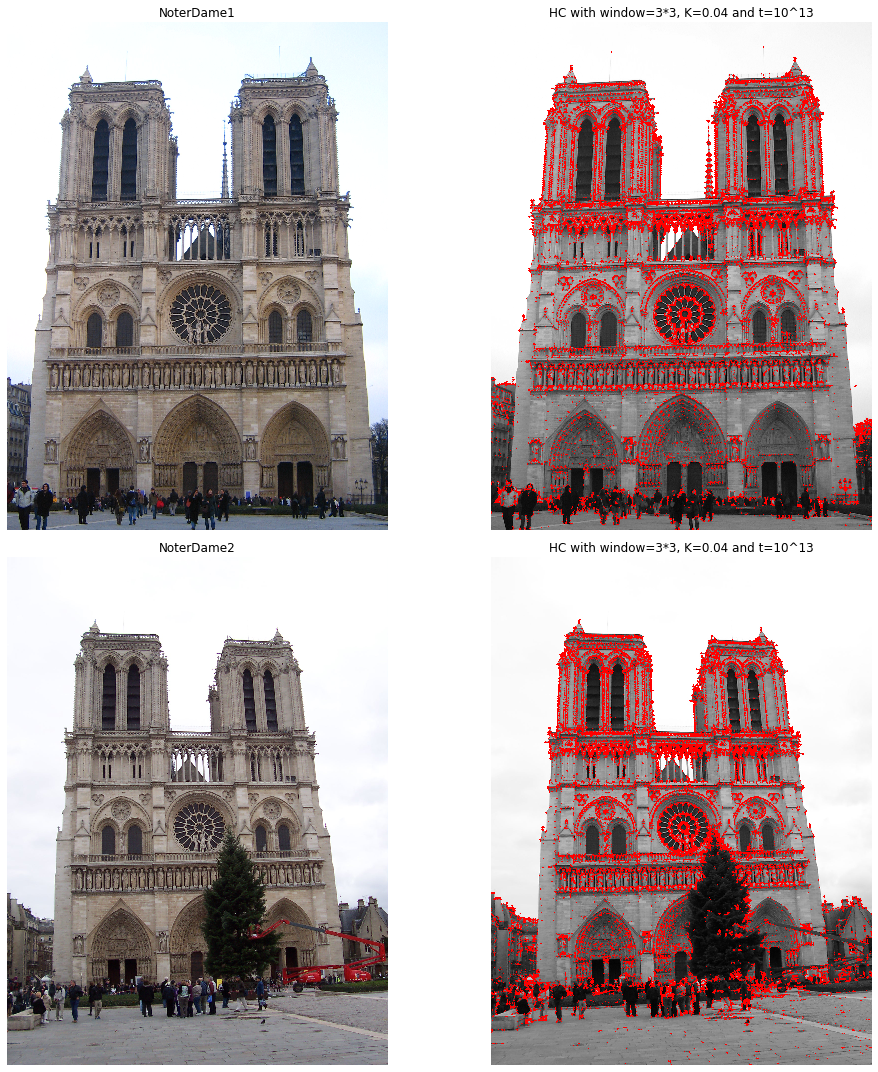

In [66]:
# Compute Harris corners of image 1
harris_corners_img1 = findHarrisCorner(gray_img1, 3, 0.01, 10000000000000) # image , window_size , k, threshold
harris_corners_img1 = np.int0(harris_corners_img1)
# Compute Harris corners of image 2
harris_corners_img2 = findHarrisCorner(gray_img2, 3, 0.01, 10000000000000) # image , window_size , k, threshold
harris_corners_img2 = np.int0(harris_corners_img2)

# Visualization
fig, ax=plt.subplots(2, 2, figsize = (15,15))

ax[0,0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('NoterDame1')
ax[0,0].axis('off')

ax[0,1].imshow(harris_corners_img1)
ax[0,1].set_title('HC with window=3*3, K=0.04 and t=10^13')
ax[0,1].axis('off')

ax[1,0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1,0].set_title('NoterDame2')
ax[1,0].axis('off')

ax[1,1].imshow(harris_corners_img2)
ax[1,1].set_title('HC with window=3*3, K=0.04 and t=10^13')
ax[1,1].axis('off')

plt.tight_layout()
plt.show()

<p id="Task_2"> <b>2. Use SIFT like or MOPS (Multiscale Oriented Patches) descriptor</b> </p>

<b>Scale Invariant Feature Transform, is a method for extracting feature vectors that describe local patches of an image.</b> <br><br>
<b>Steps of SIFT Algorithm Implementation</b>
<ol>
<li>Scale-Space Extrema Detection</li>
<li>Keypoint Localization</li>
<li>Orientation Assignment</li>
<li>Local Descriptor Creation</li>
</ol>

<b>Scale-Space Extrema Detection</b>

In [82]:
# Gaussian filter
def gaussian_filter(sigma): 
    size = 2*np.ceil(3*sigma)+1 
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1] 
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
    return g/g.sum()

In [81]:
# Generate a Gaussian octave
def generate_octave(init_level, s, sigma):
    octave = [init_level]

    k = 2**(1/s)
    kernel = gaussian_filter(k * sigma)

    for i in range(s+2):
        next_level = convolve(octave[-1], kernel)
        octave.append(next_level)

    return octave
# Generate the whole Gaussian pyramid
def generate_gaussian_pyramid(im, num_octave, s, sigma):
    pyr = []

    for _ in range(num_octave):
        octave = generate_octave(im, s, sigma)
        pyr.append(octave)
        im = octave[-3][::2, ::2]

    return pyr

In [80]:
# Create the DoG pyramid
def generate_DoG_octave(gaussian_octave):
    octave = []

    for i in range(1, len(gaussian_octave)):
        octave.append(gaussian_octave[i] - gaussian_octave[i-1])

    return np.concatenate([o[:,:,np.newaxis] for o in octave], axis=2)

def generate_DoG_pyramid(gaussian_pyramid):
    pyr = []

    for gaussian_octave in gaussian_pyramid:
        pyr.append(generate_DoG_octave(gaussian_octave))

    return pyr

<b>Extrema Detection</b>

In [79]:
# Get initial candidate keypoints from given DoG octave
def get_candidate_keypoints(D, w=16):
    candidates = []

    ''' Start '''
    # These 2 lines aren't specified in the paper but it makes it so the extrema
    # are found within the entire octave. They are always found in the first or
    # last layer so I probably have something wrong with my DoG pyramid construction.
    D[:,:,0] = 0
    D[:,:,-1] = 0
    ''' End '''
    
    # have to start at w//2 so that when getting the local w x w descriptor, we don't fall off
    for i in range(w//2+1, D.shape[0]-w//2-1):
        for j in range(w//2+1, D.shape[1]-w//2-1):
            for k in range(1, D.shape[2]-1): 
                patch = D[i-1:i+2, j-1:j+2, k-1:k+2]
                if np.argmax(patch) == 13 or np.argmin(patch) == 13:
                    candidates.append([i, j, k])

    return candidates
# Keypoint Localization
def localize_keypoint(D, x, y, s):
    dx = (D[y,x+1,s]-D[y,x-1,s])/2.
    dy = (D[y+1,x,s]-D[y-1,x,s])/2.
    ds = (D[y,x,s+1]-D[y,x,s-1])/2.

    dxx = D[y,x+1,s]-2*D[y,x,s]+D[y,x-1,s]
    dxy = ((D[y+1,x+1,s]-D[y+1,x-1,s]) - (D[y-1,x+1,s]-D[y-1,x-1,s]))/4.
    dxs = ((D[y,x+1,s+1]-D[y,x-1,s+1]) - (D[y,x+1,s-1]-D[y,x-1,s-1]))/4.
    dyy = D[y+1,x,s]-2*D[y,x,s]+D[y-1,x,s]
    dys = ((D[y+1,x,s+1]-D[y-1,x,s+1]) - (D[y+1,x,s-1]-D[y-1,x,s-1]))/4.
    dss = D[y,x,s+1]-2*D[y,x,s]+D[y,x,s-1]

    J = np.array([dx, dy, ds])
    HD = np.array([
        [dxx, dxy, dxs],
        [dxy, dyy, dys],
        [dxs, dys, dss]])

    offset = -LA.inv(HD).dot(J)	# I know you're supposed to do something when an offset dimension is >0.5 but I couldn't get anything to work.
    return offset, J, HD[:2,:2], x, y, s

def find_keypoints_for_DoG_octave(D, R_th, t_c, w):
    candidates = get_candidate_keypoints(D, w)
    #print('%d candidate keypoints found' % len(candidates))

    keypoints = []

    for i, cand in enumerate(candidates):
        y, x, s = cand[0], cand[1], cand[2]
        offset, J, H, x, y, s = localize_keypoint(D, x, y, s)

        contrast = D[y,x,s] + .5*J.dot(offset)
        if abs(contrast) < t_c: continue

        w, v = LA.eig(H)
        r = w[1]/w[0]
        R = (r+1)**2 / r
        if R > R_th: continue

        kp = np.array([x, y, s]) + offset
        if kp[1] >= D.shape[0] or kp[0] >= D.shape[1]: continue # throw out boundary points because I don't want to deal with them

        keypoints.append(kp)

    #print('%d keypoints found' % len(keypoints))
    return np.array(keypoints)
# Calculate the keypoints for the whole DoG pyramid
def get_keypoints(DoG_pyr, R_th, t_c, w):
    kps = []

    for D in DoG_pyr:
        kps.append(find_keypoints_for_DoG_octave(D, R_th, t_c, w))

    return kps

<b>Orientation Assignment</b>

In [78]:
# Getting the gradient in polar coordinates
def cart_to_polar_grad(dx, dy):
    m = np.sqrt(dx**2 + dy**2)
    theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi
    return m, theta

def get_grad(L, x, y):
    dy = L[min(L.shape[0]-1, y+1),x] - L[max(0, y-1),x]
    dx = L[y,min(L.shape[1]-1, x+1)] - L[y,max(0, x-1)]
    return cart_to_polar_grad(dx, dy)
# Simply converts the continuous angle of the gradient to a histogram bin
def quantize_orientation(theta, num_bins):
    bin_width = 360//num_bins
    return int(np.floor(theta)//bin_width)

def fit_parabola(hist, binno, bin_width):
    centerval = binno*bin_width + bin_width/2.

    if binno == len(hist)-1: rightval = 360 + bin_width/2.
    else: rightval = (binno+1)*bin_width + bin_width/2.

    if binno == 0: leftval = -bin_width/2.
    else: leftval = (binno-1)*bin_width + bin_width/2.
    
    A = np.array([
        [centerval**2, centerval, 1],
        [rightval**2, rightval, 1],
        [leftval**2, leftval, 1]])
    b = np.array([
        hist[binno],
        hist[(binno+1)%len(hist)], 
        hist[(binno-1)%len(hist)]])

    x = LA.lstsq(A, b, rcond=None)[0]
    if x[0] == 0: x[0] = 1e-6
    return -x[1]/(2*x[0])
# To obtain the actual descriptors
def assign_orientation(kps, octave, num_bins=36):
    new_kps = []
    bin_width = 360//num_bins

    for kp in kps:
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)

        sigma = kp[2]*1.5
        w = int(2*np.ceil(sigma)+1)
        kernel = gaussian_filter(sigma)

        L = octave[...,s]
        hist = np.zeros(num_bins, dtype=np.float32)

        for oy in range(-w, w+1):
            for ox in range(-w, w+1):
                x, y = cx+ox, cy+oy
                
                if x < 0 or x > octave.shape[1]-1: continue
                elif y < 0 or y > octave.shape[0]-1: continue
                
                m, theta = get_grad(L, x, y)
                weight = kernel[oy+w, ox+w] * m

                bin = quantize_orientation(theta, num_bins)
                hist[bin] += weight

        max_bin = np.argmax(hist)
        new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, max_bin, bin_width)])

        max_val = np.max(hist)
        for binno, val in enumerate(hist):
            if binno == max_bin: continue

            if .8 * max_val <= val:
                new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, binno, bin_width)])

    return np.array(new_kps)

In [74]:
# To calculate the gradients across the patch
def get_patch_grads(p):
    r1 = np.zeros_like(p)
    r1[-1] = p[-1]
    r1[:-1] = p[1:]

    r2 = np.zeros_like(p)
    r2[0] = p[0]
    r2[1:] = p[:-1]

    dy = r1-r2

    r1[:,-1] = p[:,-1]
    r1[:,:-1] = p[:,1:]

    r2[:,0] = p[:,0]
    r2[:,1:] = p[:,:-1]

    dx = r1-r2

    return dx, dy
# To create the histogram for each subregion
def get_histogram_for_subregion(m, theta, num_bin, reference_angle, bin_width, subregion_w):
    hist = np.zeros(num_bin, dtype=np.float32)
    c = subregion_w/2 - .5

    for i, (mag, angle) in enumerate(zip(m, theta)):
        angle = (angle-reference_angle) % 360
        binno = quantize_orientation(angle, num_bin)
        vote = mag

        # binno*bin_width is the start angle of the histogram bin
        # binno*bin_width+bin_width/2 is the center of the histogram bin
        # angle - " is the distance from the angle to the center of the bin 
        hist_interp_weight = 1 - abs(angle - (binno*bin_width + bin_width/2))/(bin_width/2)
        vote *= max(hist_interp_weight, 1e-6)

        gy, gx = np.unravel_index(i, (subregion_w, subregion_w))
        x_interp_weight = max(1 - abs(gx - c)/c, 1e-6)
        y_interp_weight = max(1 - abs(gy - c)/c, 1e-6)
        vote *= x_interp_weight * y_interp_weight

        hist[binno] += vote

    return hist
# Local Descriptor Creation
def get_local_descriptors(kps, octave, w=16, num_subregion=4, num_bin=8):
    descs = []
    bin_width = 360//num_bin

    for kp in kps:
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)
        kernel = gaussian_filter(w/6) # gaussian_filter multiplies sigma by 3
        L = octave[...,s]

        t, l = max(0, cy-w//2), max(0, cx-w//2)
        b, r = min(L.shape[0], cy+w//2+1), min(L.shape[1], cx+w//2+1)
        patch = L[t:b, l:r]

        dx, dy = get_patch_grads(patch)

        if dx.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dx.shape[0]:]
            else: kernel = kernel[:dx.shape[0]]
        if dx.shape[1] < w+1:
            if l == 0: kernel = kernel[kernel.shape[1]-dx.shape[1]:]
            else: kernel = kernel[:dx.shape[1]]

        if dy.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dy.shape[0]:]
            else: kernel = kernel[:dy.shape[0]]
        if dy.shape[1] < w+1:
            if l == 0: kernel = kernel[kernel.shape[1]-dy.shape[1]:]
            else: kernel = kernel[:dy.shape[1]]

        m, theta = cart_to_polar_grad(dx, dy)
        dx, dy = dx*kernel, dy*kernel

        subregion_w = w//num_subregion
        featvec = np.zeros(num_bin * num_subregion**2, dtype=np.float32)

        for i in range(0, subregion_w):
            for j in range(0, subregion_w):
                t, l = i*subregion_w, j*subregion_w
                b, r = min(L.shape[0], (i+1)*subregion_w), min(L.shape[1], (j+1)*subregion_w)

                hist = get_histogram_for_subregion(m[t:b, l:r].ravel(), 
                                                theta[t:b, l:r].ravel(), 
                                                num_bin, 
                                                kp[3], 
                                                bin_width,
                                                subregion_w)
                featvec[i*subregion_w*num_bin + j*num_bin:i*subregion_w*num_bin + (j+1)*num_bin] = hist.flatten()

        featvec /= max(1e-6, LA.norm(featvec))
        featvec[featvec>0.2] = 0.2
        featvec /= max(1e-6, LA.norm(featvec))
        descs.append(featvec)

    return np.array(descs)

In [89]:
class SIFT(object):
    def __init__(self, im, s=3, num_octave=4, s0=1.3, sigma=1.6, r_th=10, t_c=0.03, w=16):
        self.im = ndimage.convolve(rgb2gray(im), gaussian_filter(s0))
        self.s = s
        self.sigma = sigma
        self.num_octave = num_octave
        self.t_c = t_c
        self.R_th = (r_th+1)**2 / r_th
        self.w = w

    def get_features(self):
        gaussian_pyr = generate_gaussian_pyramid(self.im, self.num_octave, self.s, self.sigma)
        DoG_pyr = generate_DoG_pyramid(gaussian_pyr)
        kp_pyr = get_keypoints(DoG_pyr, self.R_th, self.t_c, self.w)
        feats = []

        for i, DoG_octave in enumerate(DoG_pyr):
            kp_pyr[i] = assign_orientation(kp_pyr[i], DoG_octave)
            feats.append(get_local_descriptors(kp_pyr[i], DoG_octave))

        self.kp_pyr = kp_pyr
        self.feats = feats

        return feats

In [ ]:
if __name__ == '__main__':
    num_img = 3

    kp_pyrs = []
    ims = []

    for i in range(1, num_img+1):
        im = imread('NotreDame1.JPG')
        im = imread('NotreDame2.JPG')

        sift_detector = SIFT(im)
        _ = sift_detector.get_features()
        kp_pyrs.append(sift_detector.kp_pyr)

    for i in range(len(kp_pyrs[0])):
        _, ax = plt.subplots(1, 3)
        ax[0].imshow(ims[0])

        kps = kp_pyrs[0][i]*(2**i)
        ax[0].scatter(kps[:,0], kps[:,1], c='b', s=2.5)

        ax[1].imshow(ims[1])

        kps = kp_pyrs[1][i]*(2**i)
        ax[1].scatter(kps[:,0], kps[:,1], c='b', s=2.5)

        ax[2].imshow(ims[2])

        kps = kp_pyrs[2][i]*(2**i)
        ax[2].scatter(kps[:,0], kps[:,1], c='b', s=2.5)

        plt.show()

(-0.5, 489.5, 605.5, -0.5)

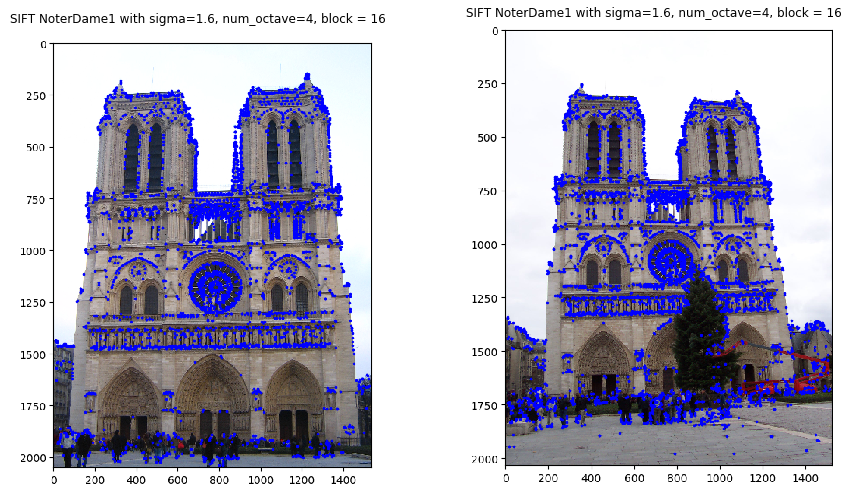

In [98]:
# Vis
sift_img1 = cv2.imread('sift_img1.PNG')
sift_img2 = cv2.imread('sift_img2.PNG')
fig, (ax1, ax2)=plt.subplots(1, 2, figsize = (15,15), sharey=True)

ax1.imshow(cv2.cvtColor(sift_img1, cv2.COLOR_BGR2RGB)) 
ax1.set_title('SIFT NoterDame1 with sigma=1.6, num_octave=4, block = 16')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(sift_img2, cv2.COLOR_BGR2RGB))
ax2.set_title('SIFT NoterDame1 with sigma=1.6, num_octave=4, block = 16')
ax2.axis('off')

<p id = 'Task_3'><b>3. Find matches   among   the   key   points   using different   (Euclidian, cosine similarity, correlation, SSD,Nearest neighbor ratio)</b></p>

<b>Euclidian Matching </b>

SIFT detected Keypoints 2001
SIFT detected Keypoints 2001


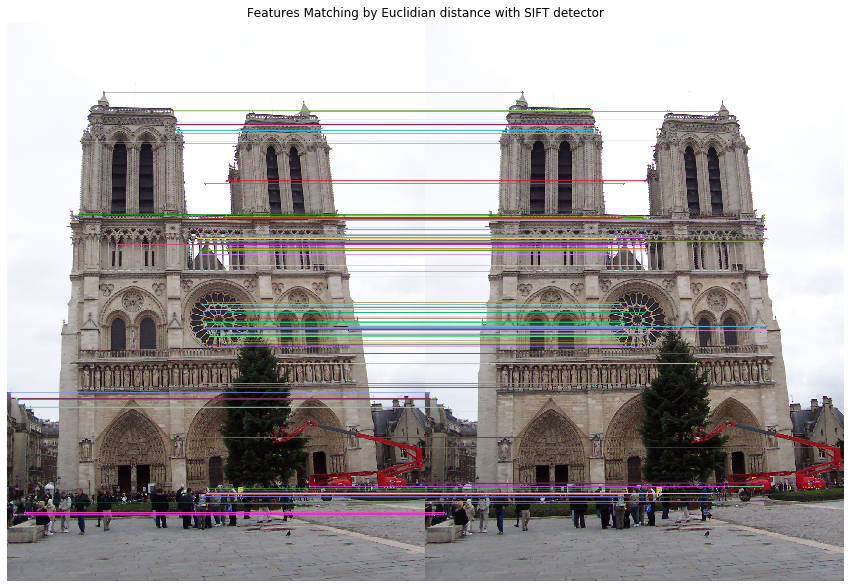

(<Figure size 1080x1080 with 1 Axes>,
 (-0.5, 3047.5, 2031.5, -0.5),
 Text(0.5, 1, 'Features Matching by Euclidian distance with SIFT detector'),
 None)

In [23]:
# Read Images
img1 = cv2.imread('NotreDame1.jpg')
img1 = cv2.imread('NotreDame2.jpg')
# instantiate SIFT object
sift = cv2.xfeatures2d.SIFT_create(2000)
# calculate keypoints and their orientation
kps_1, descriptors_1 = sift.detectAndCompute(img1, None)
kps_2, descriptors_2 = sift.detectAndCompute(img2, None)
print("SIFT detected Keypoints", len(kps_1))
print("SIFT detected Keypoints", len(kps_2))
# create BFMatcher object
bf = cv2.BFMatcher()
# Match descriptors.
matches = bf.match(descriptors_1,descriptors_2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 300 matches
img3 = cv2.drawMatches(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB),kps_1,cv2.cvtColor(img2, cv2.COLOR_BGR2RGB),kps_2,matches[:300], None, flags=2)
plt.figure(figsize = (15,15)), plt.imshow(img3),plt.axis('off'),plt.title('Features Matching by Euclidian distance with SIFT detector'), plt.show()

<b>Feature Matching by Nearest Neighbor Distance Ratio </b>

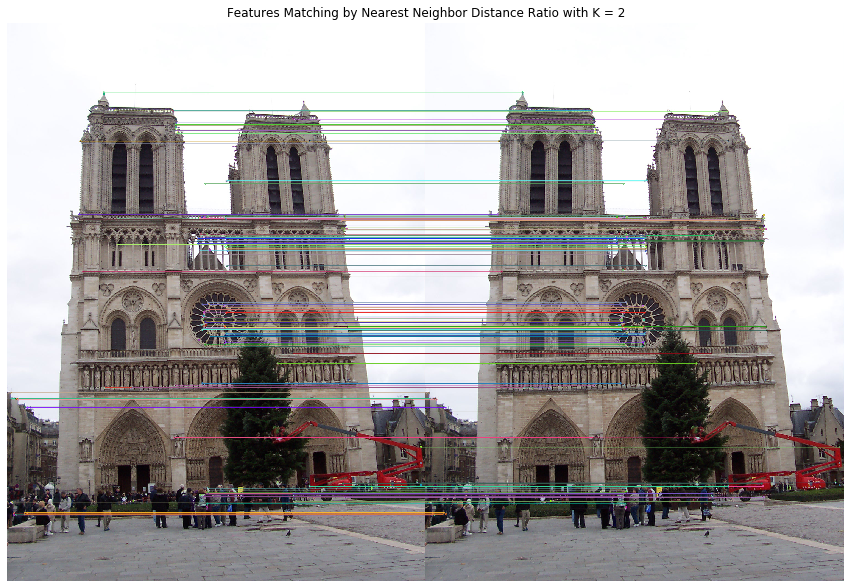

In [26]:
# matching the descriptors from both the images 
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_1,descriptors_2,k = 2)
# selecting only the good features with KNN
good_matches = []
ratio = 0.75
for m,n in matches:
    if m.distance < ratio*n.distance:
        good_matches.append([m])

image3 = cv2.drawMatchesKnn(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB),kps_1,cv2.cvtColor(img2, cv2.COLOR_BGR2RGB),kps_2,good_matches[:300], None, flags = 2)
plt.figure(figsize = (15,15))
plt.title('Features Matching by Nearest Neighbor Distance Ratio with K = 2')
plt.axis('off')
plt.imshow(image3)

<b>Note:</b> If you decrease the ratio value, for example to 0.1 you will get really high quality matches, but the downside is that you will get only few matches.

<p id = 'Task_4'><b>4. Manually/Automatically chose at least four matching pair and represent and show them as Ah=0 form, where h is projective transformation / homography parameters.</b></p>

In [28]:
# Computers a homography from 4-correspondences
randomFour = []
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

# Calculate the geometric distance between estimated points and original points
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

# Runs through ransac algorithm, creating homographies from random correspondences
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
       # print ("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers, randomFour


In [30]:
# Main parses argument list and runs the functions
estimation_thresh = 0.60

#query image
img1 = cv2.imread('NotreDame1.jpg')
#train image
img2 = cv2.imread('NotreDame2.jpg')
sift = cv2.xfeatures2d.SIFT_create()
# calculate keypoints and their orientation
kps_1, descriptors_1 = sift.detectAndCompute(img1, None)
kps_2, descriptors_2 = sift.detectAndCompute(img2, None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# Match descriptors.
matches = bf.match(descriptors_1,descriptors_2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Find features and keypoints
correspondenceList = []
keypoints = [kps_1,kps_2]
for match in matches:
    (x1, y1) = keypoints[0][match.queryIdx].pt
    (x2, y2) = keypoints[1][match.trainIdx].pt
    correspondenceList.append([x1, y1, x2, y2])

corrs = np.matrix(correspondenceList)

# Run ransac algorithm
finalH, inliers, randomFour = ransac(corrs, estimation_thresh)
Homography_Mat = finalH


Final inliers count:  1427


In [38]:
print('\nRandom Four points by RANSAC Algorithm:\n\n', np.int0(randomFour))


Random Four points by RANSAC Algorithm:

 [[1306  596  529 1340]
 [1290 1447 1211 1296]
 [1003  962  961  906]
 [ 308 1090  717  940]]


<p id = 'Task_5'><b>5. Find homography matrix H by solving the Eqn Ah=0 using the technique of solving Homogeneous linear system or Homogeneous least square linear system.</b></p>

In [44]:
# Homography Matrix 
print ("\nHomography Matrix: \n\n", Homography_Mat)
# Count inliers through RANSAC Algorithm 
print ("\nFinal inliers count: ", len(inliers))


Homography Matrix: 

 [[ 9.18243571e-01  2.87152940e-02  5.94962796e+01]
 [ 9.98653032e-02  8.09372391e-01  7.50341831e+01]
 [ 8.26893237e-05 -3.15529440e-05  1.00000000e+00]]

Final inliers count:  1427


<p id = 'Task_6'><b>6. Apply H to transform first image into a homographic transformed version using backward warping, also show all the images (first, 2nd, and the homographic transformed) side-by-side. Also show the difference between 2nd and transformed images.</b></p>

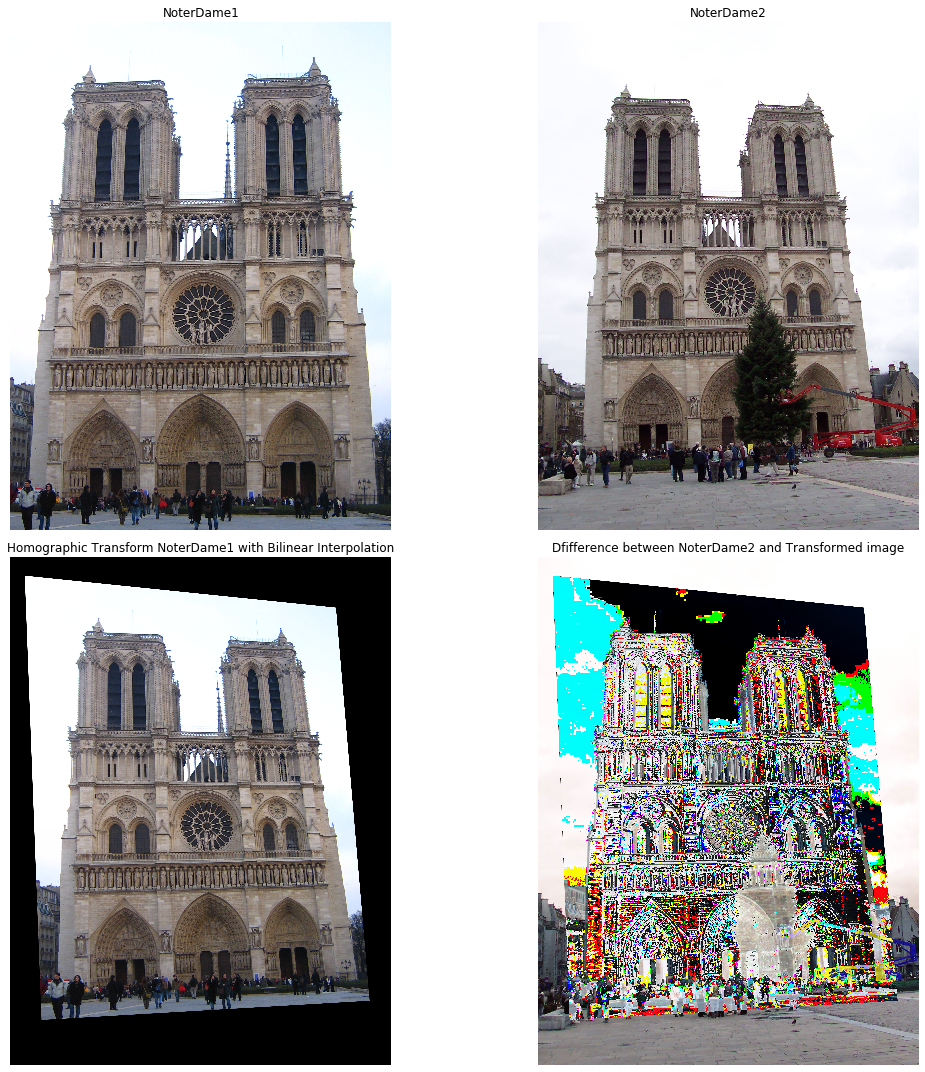

In [72]:
# Homography Matrix 
Homography_Mat = Homography_Mat
# Homographic Tranformed done by Homographic Matrix of Image 1 
homographic_transformed = cv2.warpPerspective(img1,Homography_Mat, (img2.shape[1], img2.shape[0]), flags=cv2.INTER_LINEAR) # image, H-Matrix, img shape, flags = Bilinear Interpolation 
# Difference Between 2nd and Homographic Transform image 
difference = img2 - homographic_transformed

# Visualization
fig, ax=plt.subplots(2, 2, figsize = (15,15))

ax[0,0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)) 
ax[0,0].set_title('NoterDame1')
ax[0,0].axis('off')

ax[0,1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[0,1].set_title('NoterDame2')
ax[0,1].axis('off')

ax[1,0].imshow(cv2.cvtColor(homographic_transformed, cv2.COLOR_BGR2RGB))
ax[1,0].set_title('Homographic Transform NoterDame1 with Bilinear Interpolation')
ax[1,0].axis('off')

ax[1,1].imshow(difference, cmap = 'gray')
ax[1,1].set_title('Dfifference between NoterDame2 and Transformed image')
ax[1,1].axis('off')

plt.tight_layout()
plt.show()

<div align = "right"><a href="#top">Go to Top</a></div>